## About
This notebook compares the _runtime_ performance of STARLING, IDPFold, and IDPForge. In all cases, ensembles were generated on the same hardware (NVIDIA A4000 GPU). 

MOST of the code in this notebook is defining fitting functions for exponential or linear models. We _only_ do this to "guide the eye" when we're plotting all three models on the same axis, and to enable a qualitative assessment of relative performance for IDPFold and IDPForge vs. STARLING - those fits are not being used for anything quantitative beyond these purposes, and we make no strong claims here as to where we can formally say that IDPForge and IDPFold scale exponentially with sequence length while STARLING scales linearly. This is what it _looks_ like but we do not make strong claims one way or the other here!

Comparisons here are against two state-of-the-art deep learning models.

*  [Zhu, J., Li, Z., Zheng, Z., Zhang, B., Zhong, B., Bai, J., Hong, X., Wang, T., Wei, T., Yang, J. & Chen, H.-F. Accurate generation of conformational ensembles for intrinsically disordered proteins with IDPFold. Adv. Sci. (Weinh.) e11636 (2025).](https://advanced.onlinelibrary.wiley.com/doi/10.1002/advs.202511636?af=R)
*  [Zhang, O., Liu, Z. H., Forman-Kay, J. D. & Head-Gordon, T. Deep learning of proteins with local and global regions of disorder. arXiv (q-bio.BM) (2025). at &#60;http://arxiv.org/abs/2502.11326&#62;](https://arxiv.org/abs/2502.11326)


It is worth nothing that both of these provide all-atom representations, as opposed to coarse-grained representations, so from a performance standpoint it is perhaps not surprising that these are substantially slower than STARLING. Elsewhere, we assess model accuracy in terms of ability to reproduce experimental observables.
  

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from scipy.optimize import curve_fit

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis


	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375
tqdm
# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import protfasta
import pickle


In [9]:
STARLING_COMPILE = True

idpfold = np.loadtxt('idpfold/outdata/length_vs_time_per_conformer.csv')
idpforge = np.loadtxt('idpforge/outdata/length_vs_time_per_conformer.csv')


starling_compiled = np.loadtxt('starling/starling_performance_time_per_conf_bs_100_compiled.csv')
starling = np.loadtxt('starling/starling_performance_time_per_conf_bs_100_not_compiled.csv')

In [10]:
#148 residues
print(f"Time for a 400-conformer ensemble in seconds with IDPForge: {idpforge[1][91]*400}")

Time for a 400-conformer ensemble in seconds with IDPForge: 4976.0


In [11]:
print(f"Time for a 400-conformer ensemble in seconds with IDPFold: {idpfold[1][90]*400}")


Time for a 400-conformer ensemble in seconds with IDPFold: 4197.222222222222


In [12]:
print(f"Time for a 400-conformer ensemble in seconds with STARLING (compiled): {starling_compiled[1][92]*400}")
print(f"Time for a 400-conformer ensemble in seconds with STARLING (raw): {starling[1][92]*400}")


Time for a 400-conformer ensemble in seconds with STARLING (compiled): 9.578012704849243
Time for a 400-conformer ensemble in seconds with STARLING (raw): 11.86334753036499


In [13]:
seqs = protfasta.read_fasta('starling/all_comparison_seqs.fasta')

In [14]:
def fit_to_exponential(xvals, yvals, fit_min=None, fit_max=None, use2exp=False):
    """
    Function to fit data to an exponential model. NB: This function was written
    by copilot to enable a robust 2/3-parameter exponential fit.

    Parameters:
    xvals : array-like
        The x-values of the data points.

    yvals : array-like
        The y-values of the data points.

    fit_min : float, optional
        Minimum x-value for the fitted curve (default is min of xvals).

    fit_max : float, optional
        Maximum x-value for the fitted curve (default is max of xvals).

    use2exp : bool, optional
        If True, use a 2-parameter exponential model (no offset). Default is False

    Parameters:
    ---------
    xf : array
        x-values for the fitted curve.

    yf : array
        y-values for the fitted curve.

    Example:
    --------
    xf, yf = fit_to_exponential(xdata, ydata, fit_min=0, fit_max=100, use2exp=False)
    
    """
    # define a 3-parameter exponential model
    def exp3(x, a, b, c):
        return a * np.exp(b * x) + c

    # define a 2-parameter exponential model
    def exp2(x, a, b):
        return a * np.exp(b * x)

    # Basic cleaning - find positions where either x or y is NaN
    # and only keep positions where both are valid numbers
    m = np.isfinite(xvals) & np.isfinite(yvals)
    x, y = xvals[m], yvals[m]

    # ------------------------------------------------------------
    ## Initial guesses for exp3

    # offset guess: small percentile as baseline;
    c0 = np.percentile(y, 5)

    # amplitude: using that offset define range above baseline
    amp = max(y.max() - c0, 1e-6)

    # crude slope guess (avoid log of <=0)
    eps = max(1e-9, 1e-6 * np.abs(y).max())

    # b from log-linear fit 
    yy = np.clip(y - c0, eps, None)
    b0 = np.polyfit(x, np.log(yy), 1)[0] if len(x) > 1 else 0.0
    # ------------------------------------------------------------

    p0 = (amp, b0, c0)    

    # Fit
    if use2exp is False:    
        popt, pcov = curve_fit(exp3, x, y, p0=p0, maxfev=10000)
        model = exp3
        label = "Fit: a·exp(bx)+c"
    else:
        # Fallback to 2-parameter model (no offset)
        # guesses: amplitude ~ max(y), b from log-linear of y
        yy2 = np.clip(y, eps, None)
        b02 = np.polyfit(x, np.log(yy2), 1)[0] if len(x) > 1 else 0.0
        p02 = (max(y.max(), 1e-6), b02)
        popt, pcov = curve_fit(exp2, x, y, p0=p02, maxfev=10000)
        model = exp2
        label = "Fit: a·exp(bx)"
    
    # Smooth curve for plotting
    if fit_min is None:
        fit_min = x.min()
    if fit_max is None:
        fit_max = x.max()
    
    xf = np.arange(fit_min, fit_max)
    yf = model(xf, *popt)

    return xf, yf


def fit_to_linear(xvals, yvals, fit_min=None, fit_max=None):
    """
    Function to fit data to a linear model. NB: This function was written
    by copilot to enable a robust linear fit.

    Parameters:
    xvals : array-like
        The x-values of the data points.

    yvals : array-like
        The y-values of the data points.

    fit_min : float, optional
        Minimum x-value for the fitted line (default is min of xvals).

    fit_max : float, optional
        Maximum x-value for the fitted line (default is max of xvals).

    Returns:
    ---------
    xf : array
        x-values for the fitted line.
    yf : array
        y-values for the fitted line.

    Example:
    --------
    xf, yf = fit_to_linear(xdata, ydata, fit_min=0, fit_max=100)


    """
    # Linear model
    def lin(x, m, b):
        return m * x + b

    # Basic cleaning
    msk = np.isfinite(xvals) & np.isfinite(yvals)
    x, y = xvals[msk], yvals[msk]

    # Initial guess for slope and intercept
    if len(x) > 1:
        slope_guess, intercept_guess = np.polyfit(x, y, 1)
        p0 = (slope_guess, intercept_guess)
    else:
        p0 = (1.0, 0.0)

    # Fit
    popt, pcov = curve_fit(lin, x, y, p0=p0, maxfev=10000)

    # Smooth line for plotting
    if fit_min is None:
        fit_min = x.min()
    if fit_max is None:
        fit_max = x.max()

    xf = np.arange(fit_min, fit_max)
    yf = lin(xf, *popt)

    return xf, yf  

### Compare all three models
The first figure here compares runtime in terms of seconds-per-conformer as a function of sequence length. Worth noting IDPForge has an MD-based relaxation step which is why there's a fair bit of variablity in the times (IDPFold and STARLING do not do this).

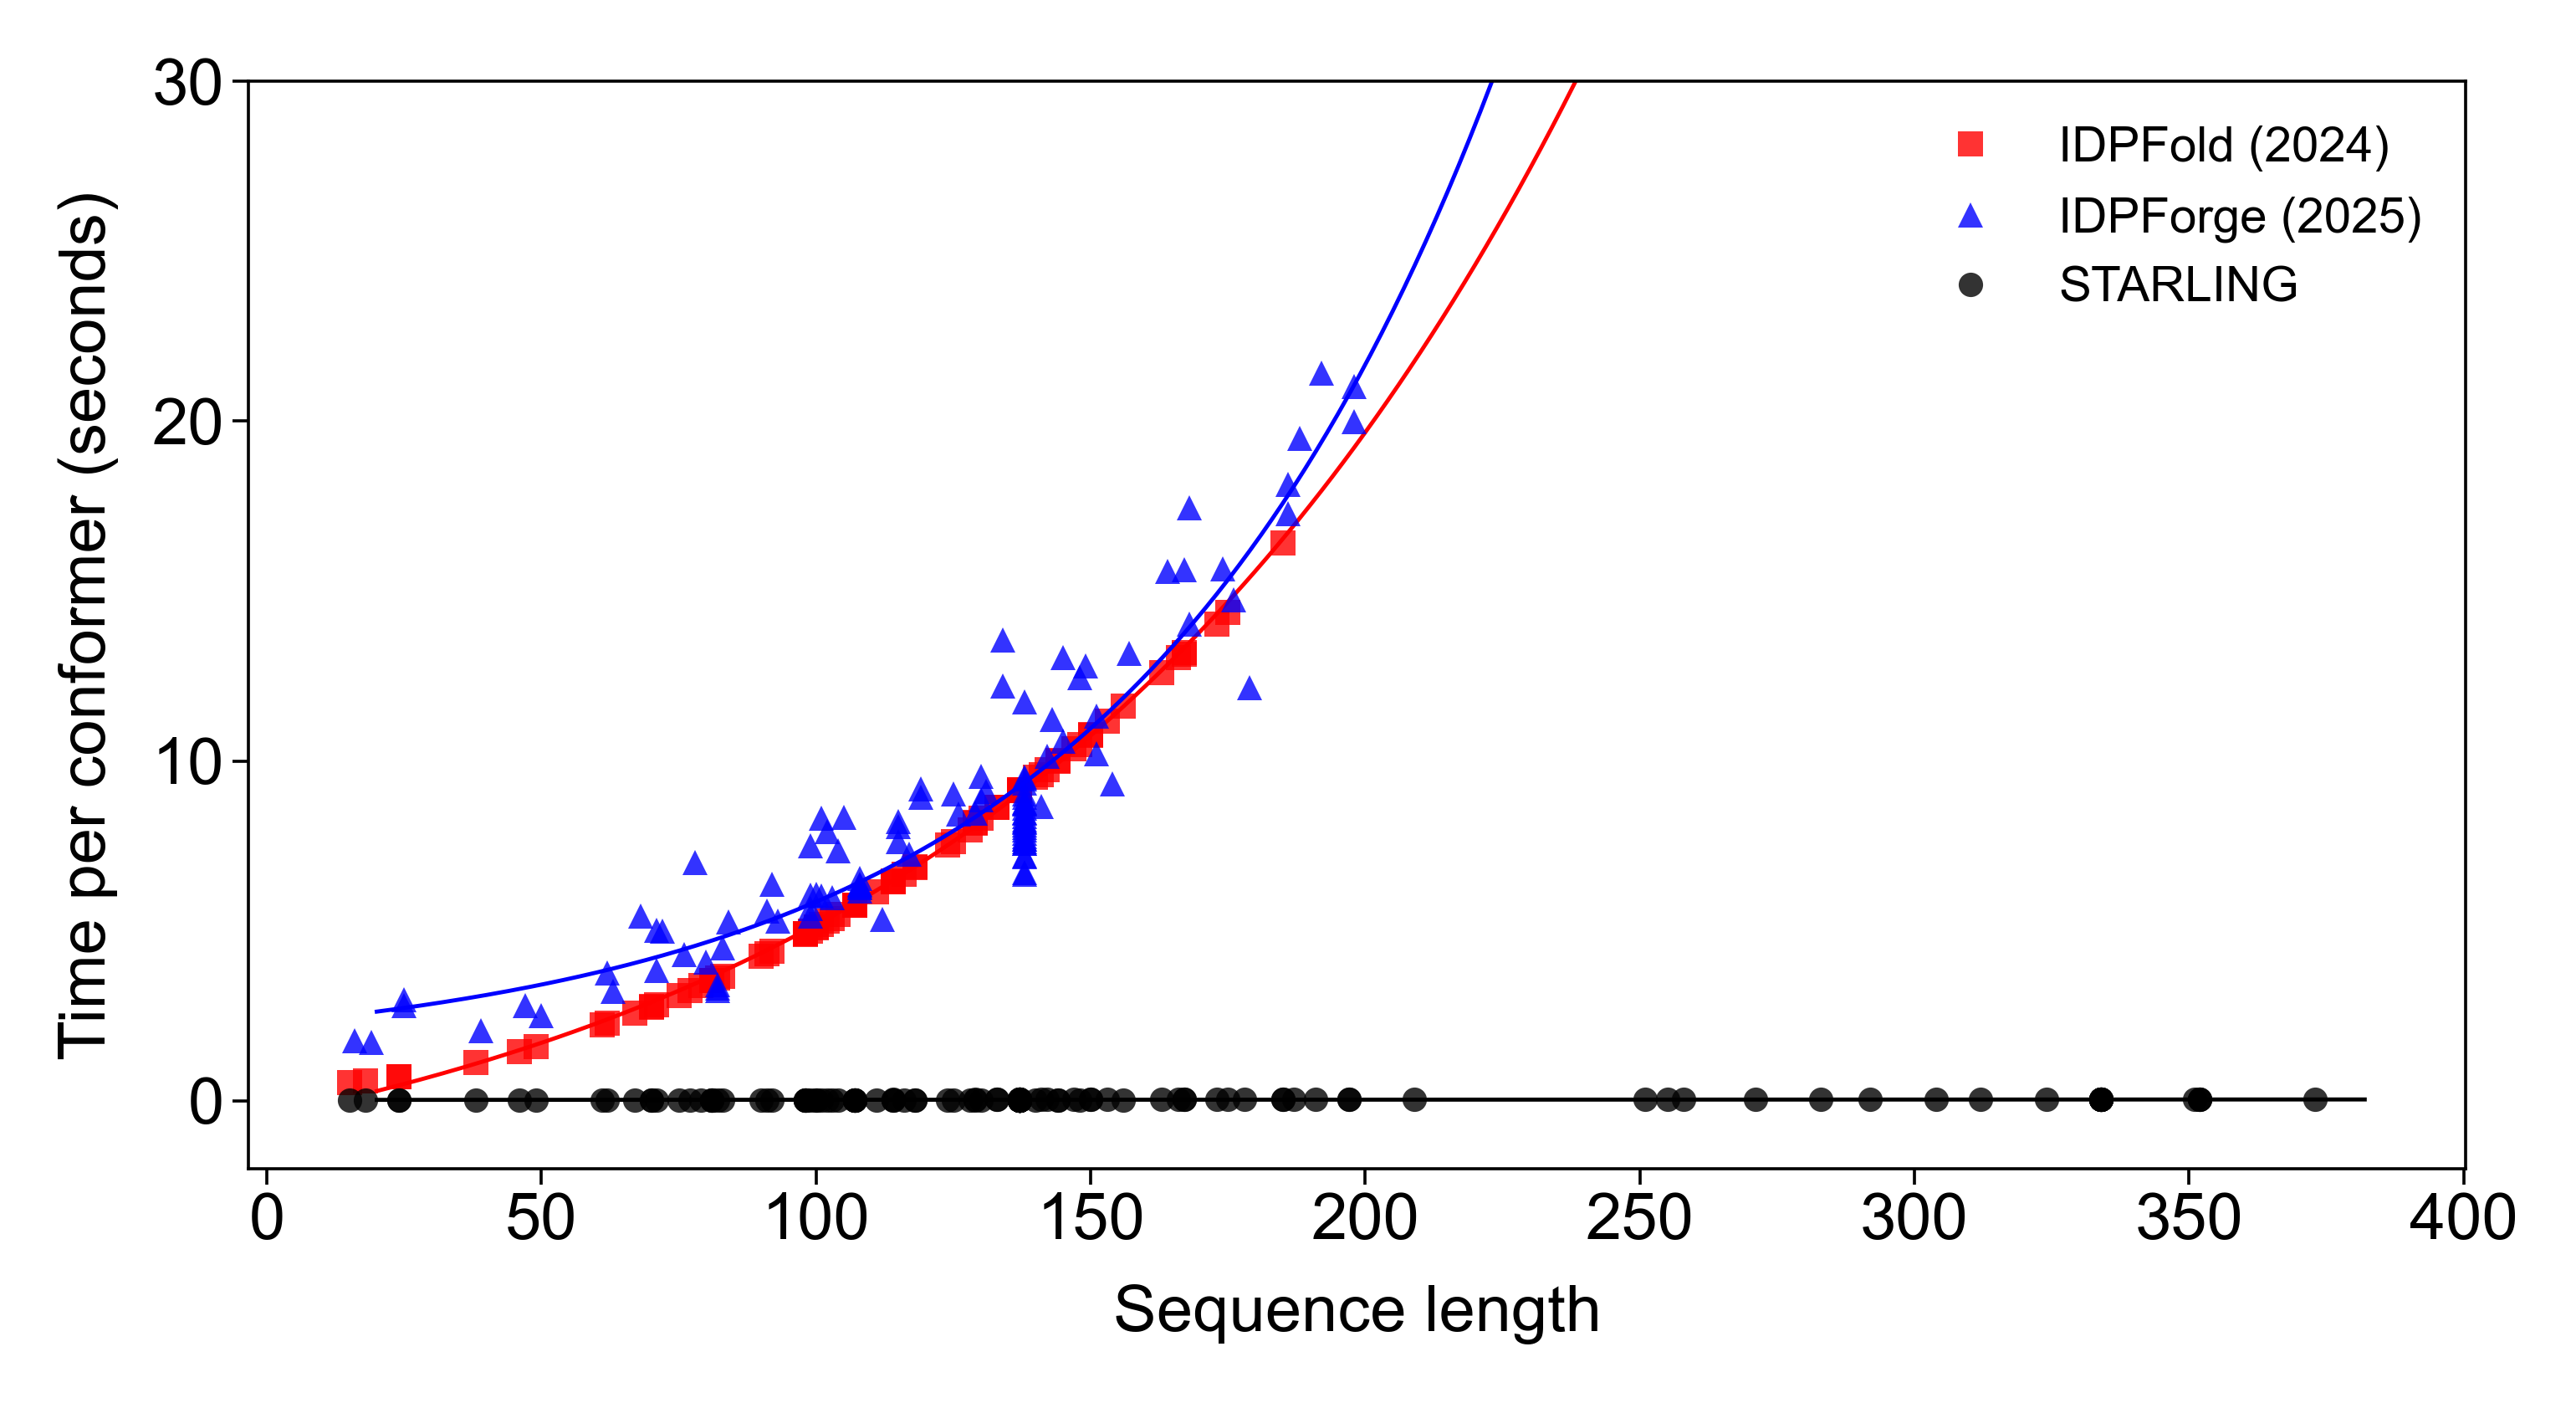

In [15]:
figure(None, (4.5,2.5), dpi=350)
ax = plt.gca()

# we fit IDPFold and IDPForge to exponetial models
plt.plot(idpfold[0], idpfold[1],'sr', ms=3, alpha=0.8,mew=0, label='IDPFold (2024)')
[xf_idpfold, yf_idpfold] = fit_to_exponential(idpfold[0], idpfold[1], fit_min=20, fit_max=383)
plt.plot(xf_idpfold, yf_idpfold, '-r', lw=0.5)

plt.plot(idpforge[0], idpforge[1],'^b', ms=3, alpha=0.8,mew=0, label='IDPForge (2025)')
[xf_idpforge, yf_idpforge] = fit_to_exponential(idpforge[0], idpforge[1], fit_min=20, fit_max=383)
plt.plot(xf_idpforge, yf_idpforge, '-b', lw=0.5)

# we fit STARLING to a linear model
plt.plot(starling[0], starling[1],'ok', ms=3, alpha=0.8,mew=0, label='STARLING')
[xf_starling, yf_starling] = fit_to_linear(starling[0], starling[1], fit_min=20, fit_max=383)
plt.plot(xf_starling, yf_starling, '-k', lw=0.5)


plt.xlabel('Sequence length',fontsize=8)
plt.ylabel('Time per conformer (seconds)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-2,30])
plt.legend(frameon=False, fontsize=6)


plt.tight_layout()
plt.savefig('figures/three_way_comparison.pdf')



## Comparing compiled vs. non-compiled
STARLING allows you to optimize runtime performance using PyTorch'es compile() function. For (much) more information on this, [please see our docs](https://idptools-starling.readthedocs.io/en/latest/usage/performance.html) - here we compare the most BASIC compilation comparison, where if `compile()` is used it simply means we called:

    
    starling.set_compilation_options(enabled=True)

Before the code was executed.

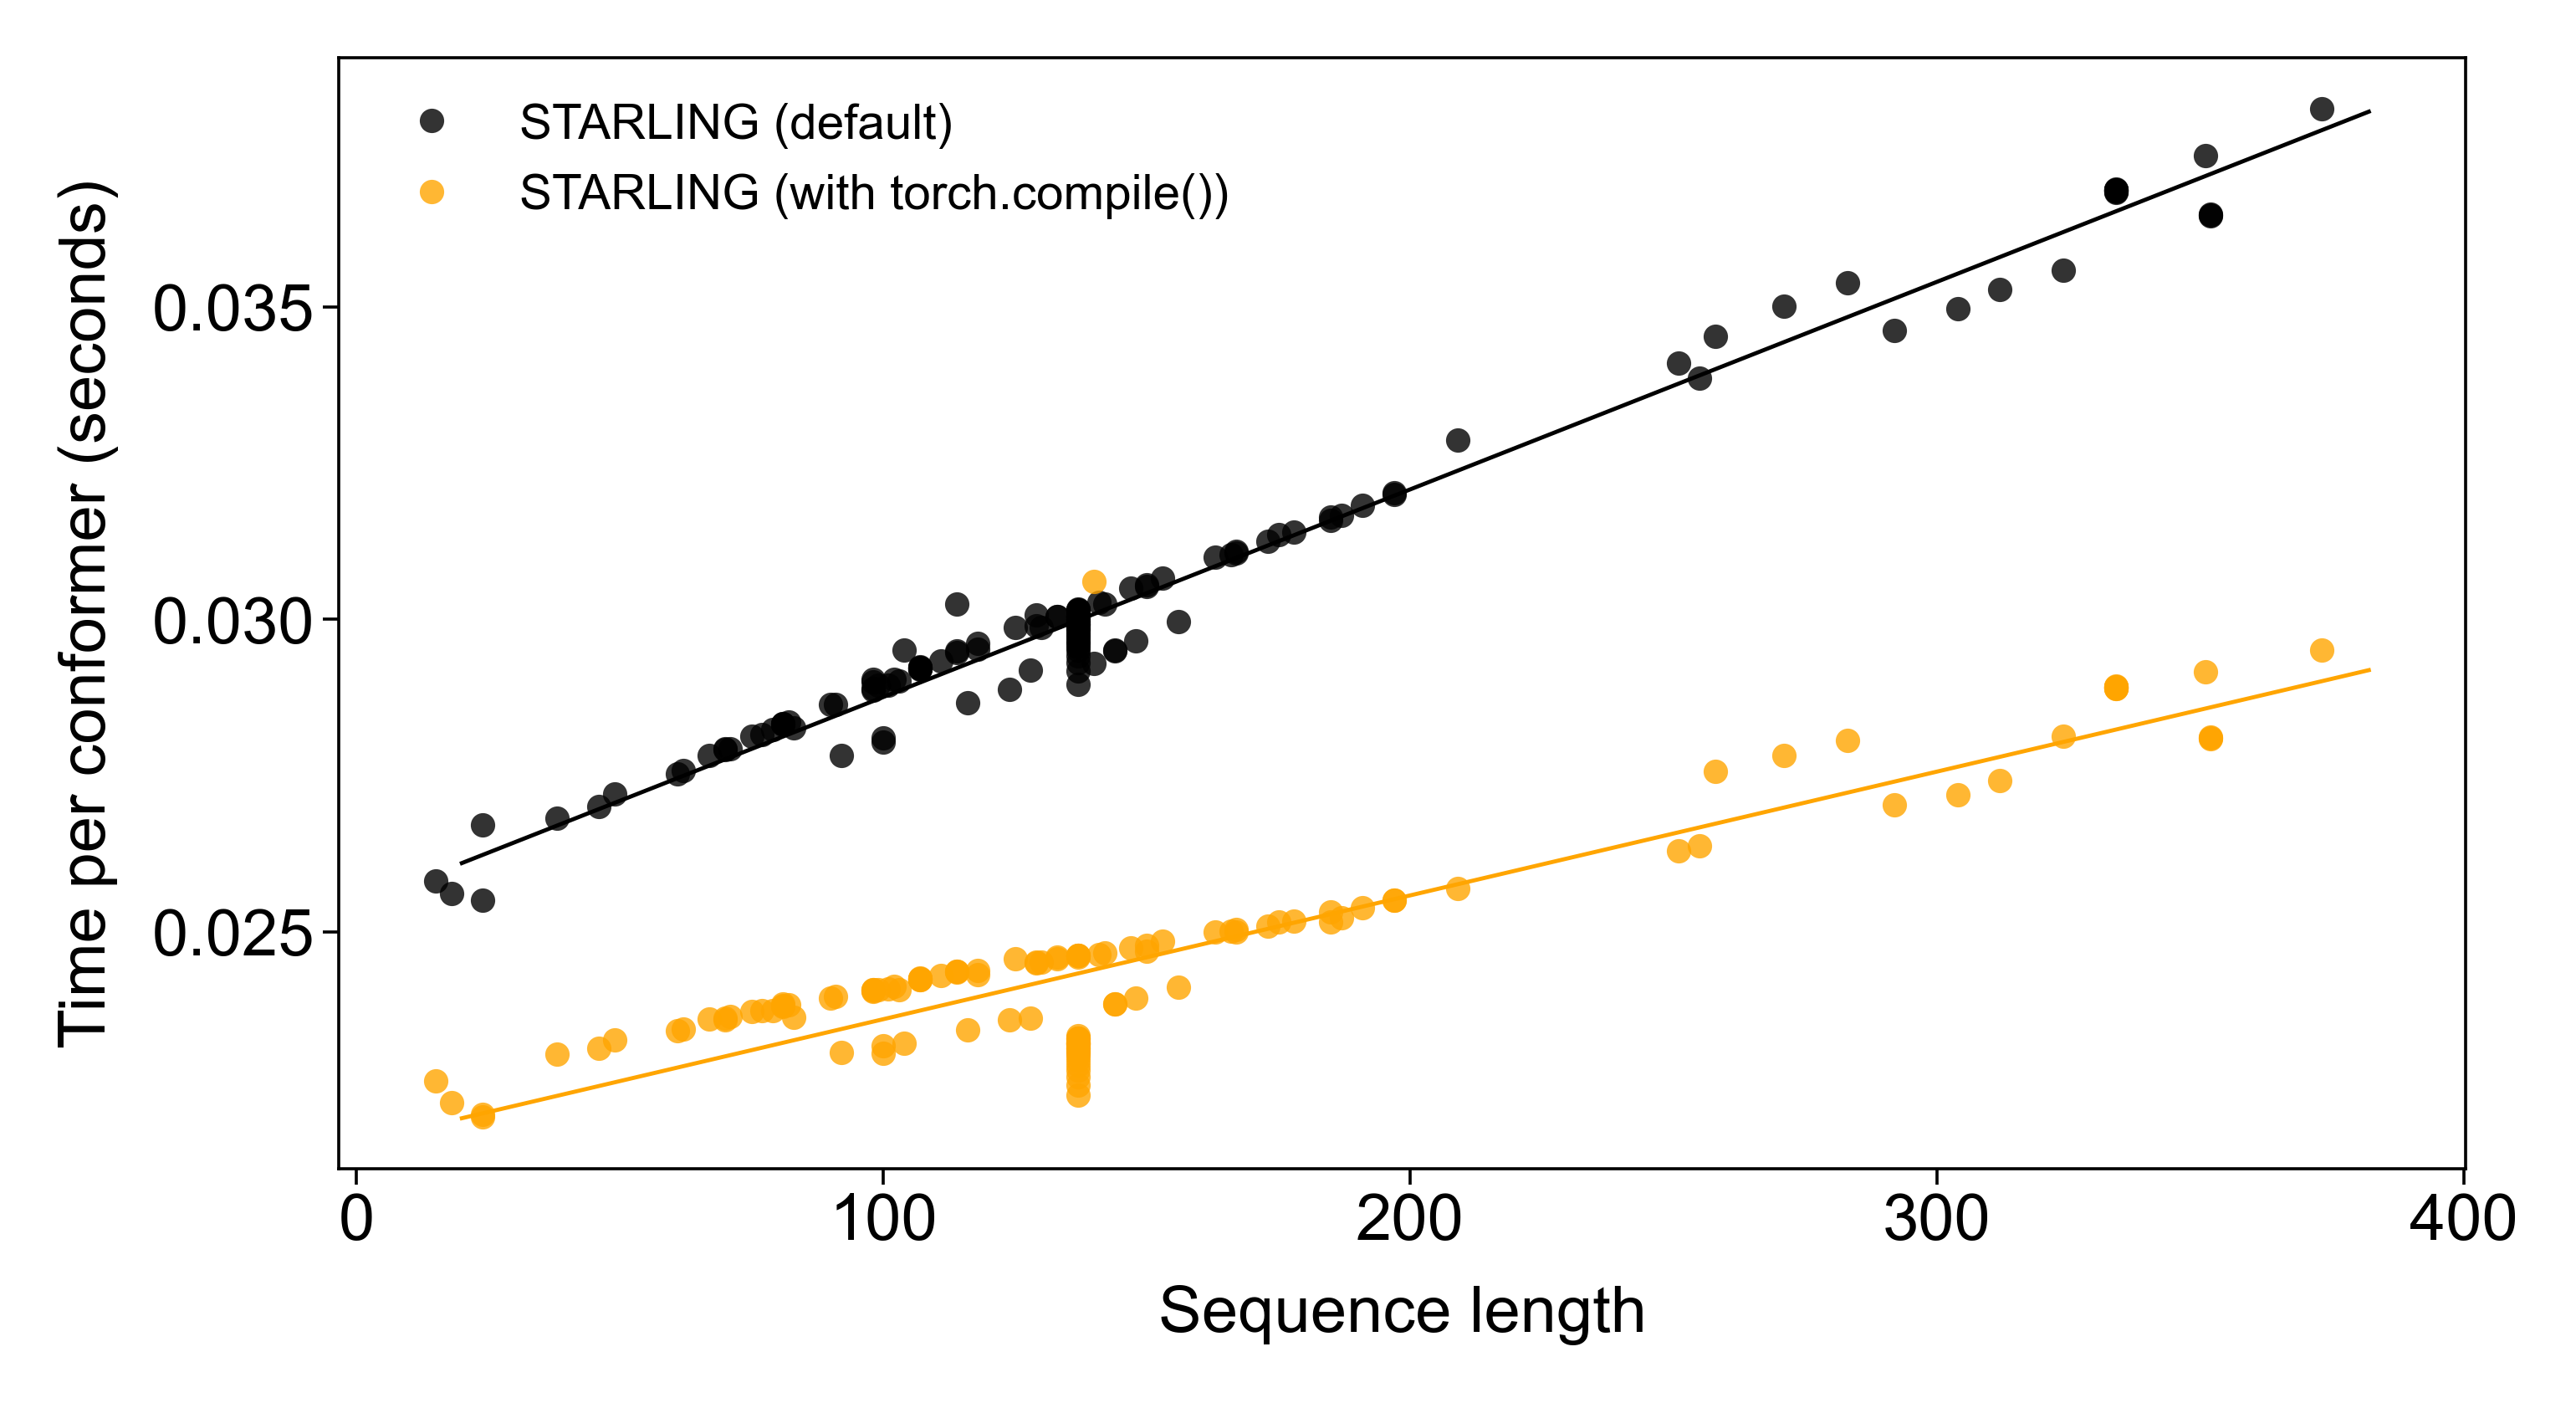

In [16]:
figure(None, (4.5,2.5), dpi=350)
ax = plt.gca()

plt.plot(starling[0], starling[1],'ok', ms=3, alpha=0.8,mew=0, label='STARLING (default)')
[xf_starling, yf_starling] = fit_to_linear(starling[0], starling[1], fit_min=20, fit_max=383)
plt.plot(xf_starling, yf_starling, '-k', lw=0.5)


plt.plot(starling_compiled[0], starling_compiled[1],'o', ms=3, alpha=0.8, mew=0, label='STARLING (with torch.compile())', color='orange')
[xf_starling_c, yf_starling_c] = fit_to_linear(starling_compiled[0], starling_compiled[1], fit_min=20, fit_max=383)
plt.plot(xf_starling_c, yf_starling_c, '-', lw=0.5, color='orange')

plt.xlabel('Sequence length',fontsize=8)
plt.ylabel('Time per conformer (seconds)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
#plt.ylim([0,0.06])

plt.legend(frameon=False, fontsize=6)


plt.tight_layout()
plt.savefig('figures/starling_only.pdf')



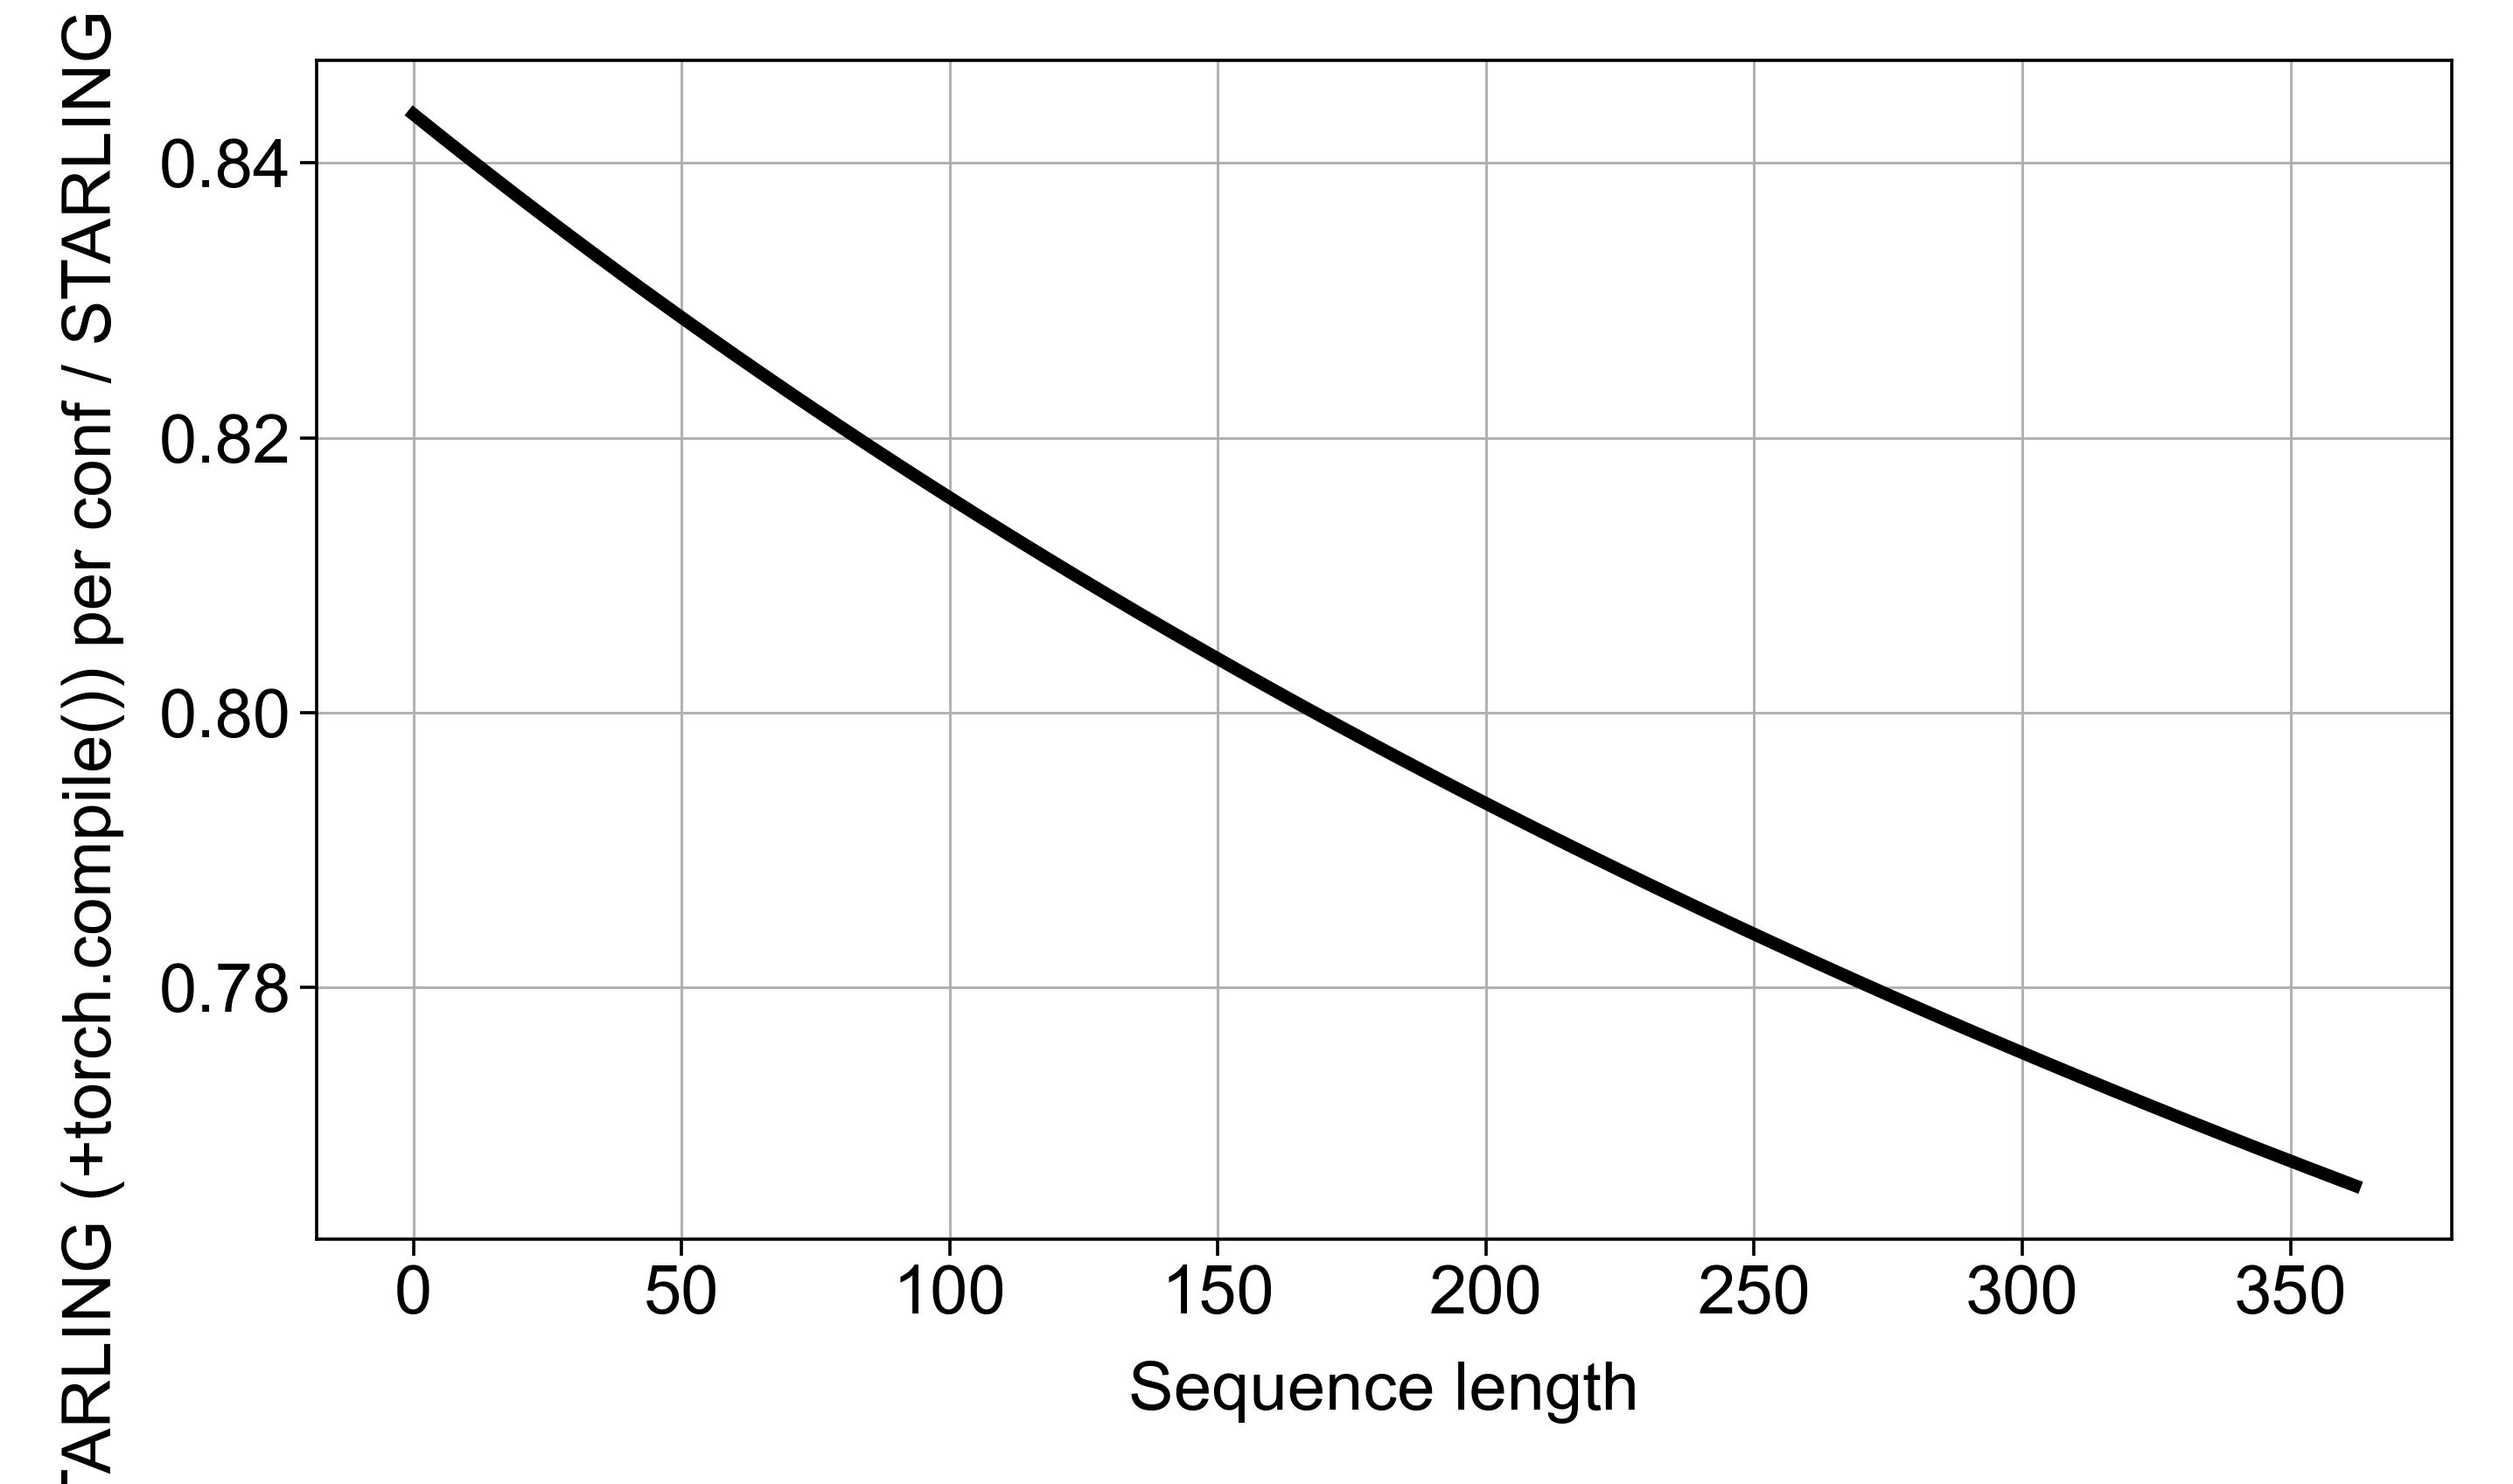

In [17]:
# compute relative speedup of compiled vs non-compiled
# note here smaller number means compile is faster
figure(None, (4.5,2.5), dpi=350)
ax = plt.gca()

plt.plot(yf_starling_c/yf_starling, color='k')
plt.grid(lw=0.3)
plt.xlabel('Sequence length',fontsize=8)
plt.ylabel('STARLING (+torch.compile()) per conf / STARLING per conf', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig('figures/relative_speed_starling_only.pdf')



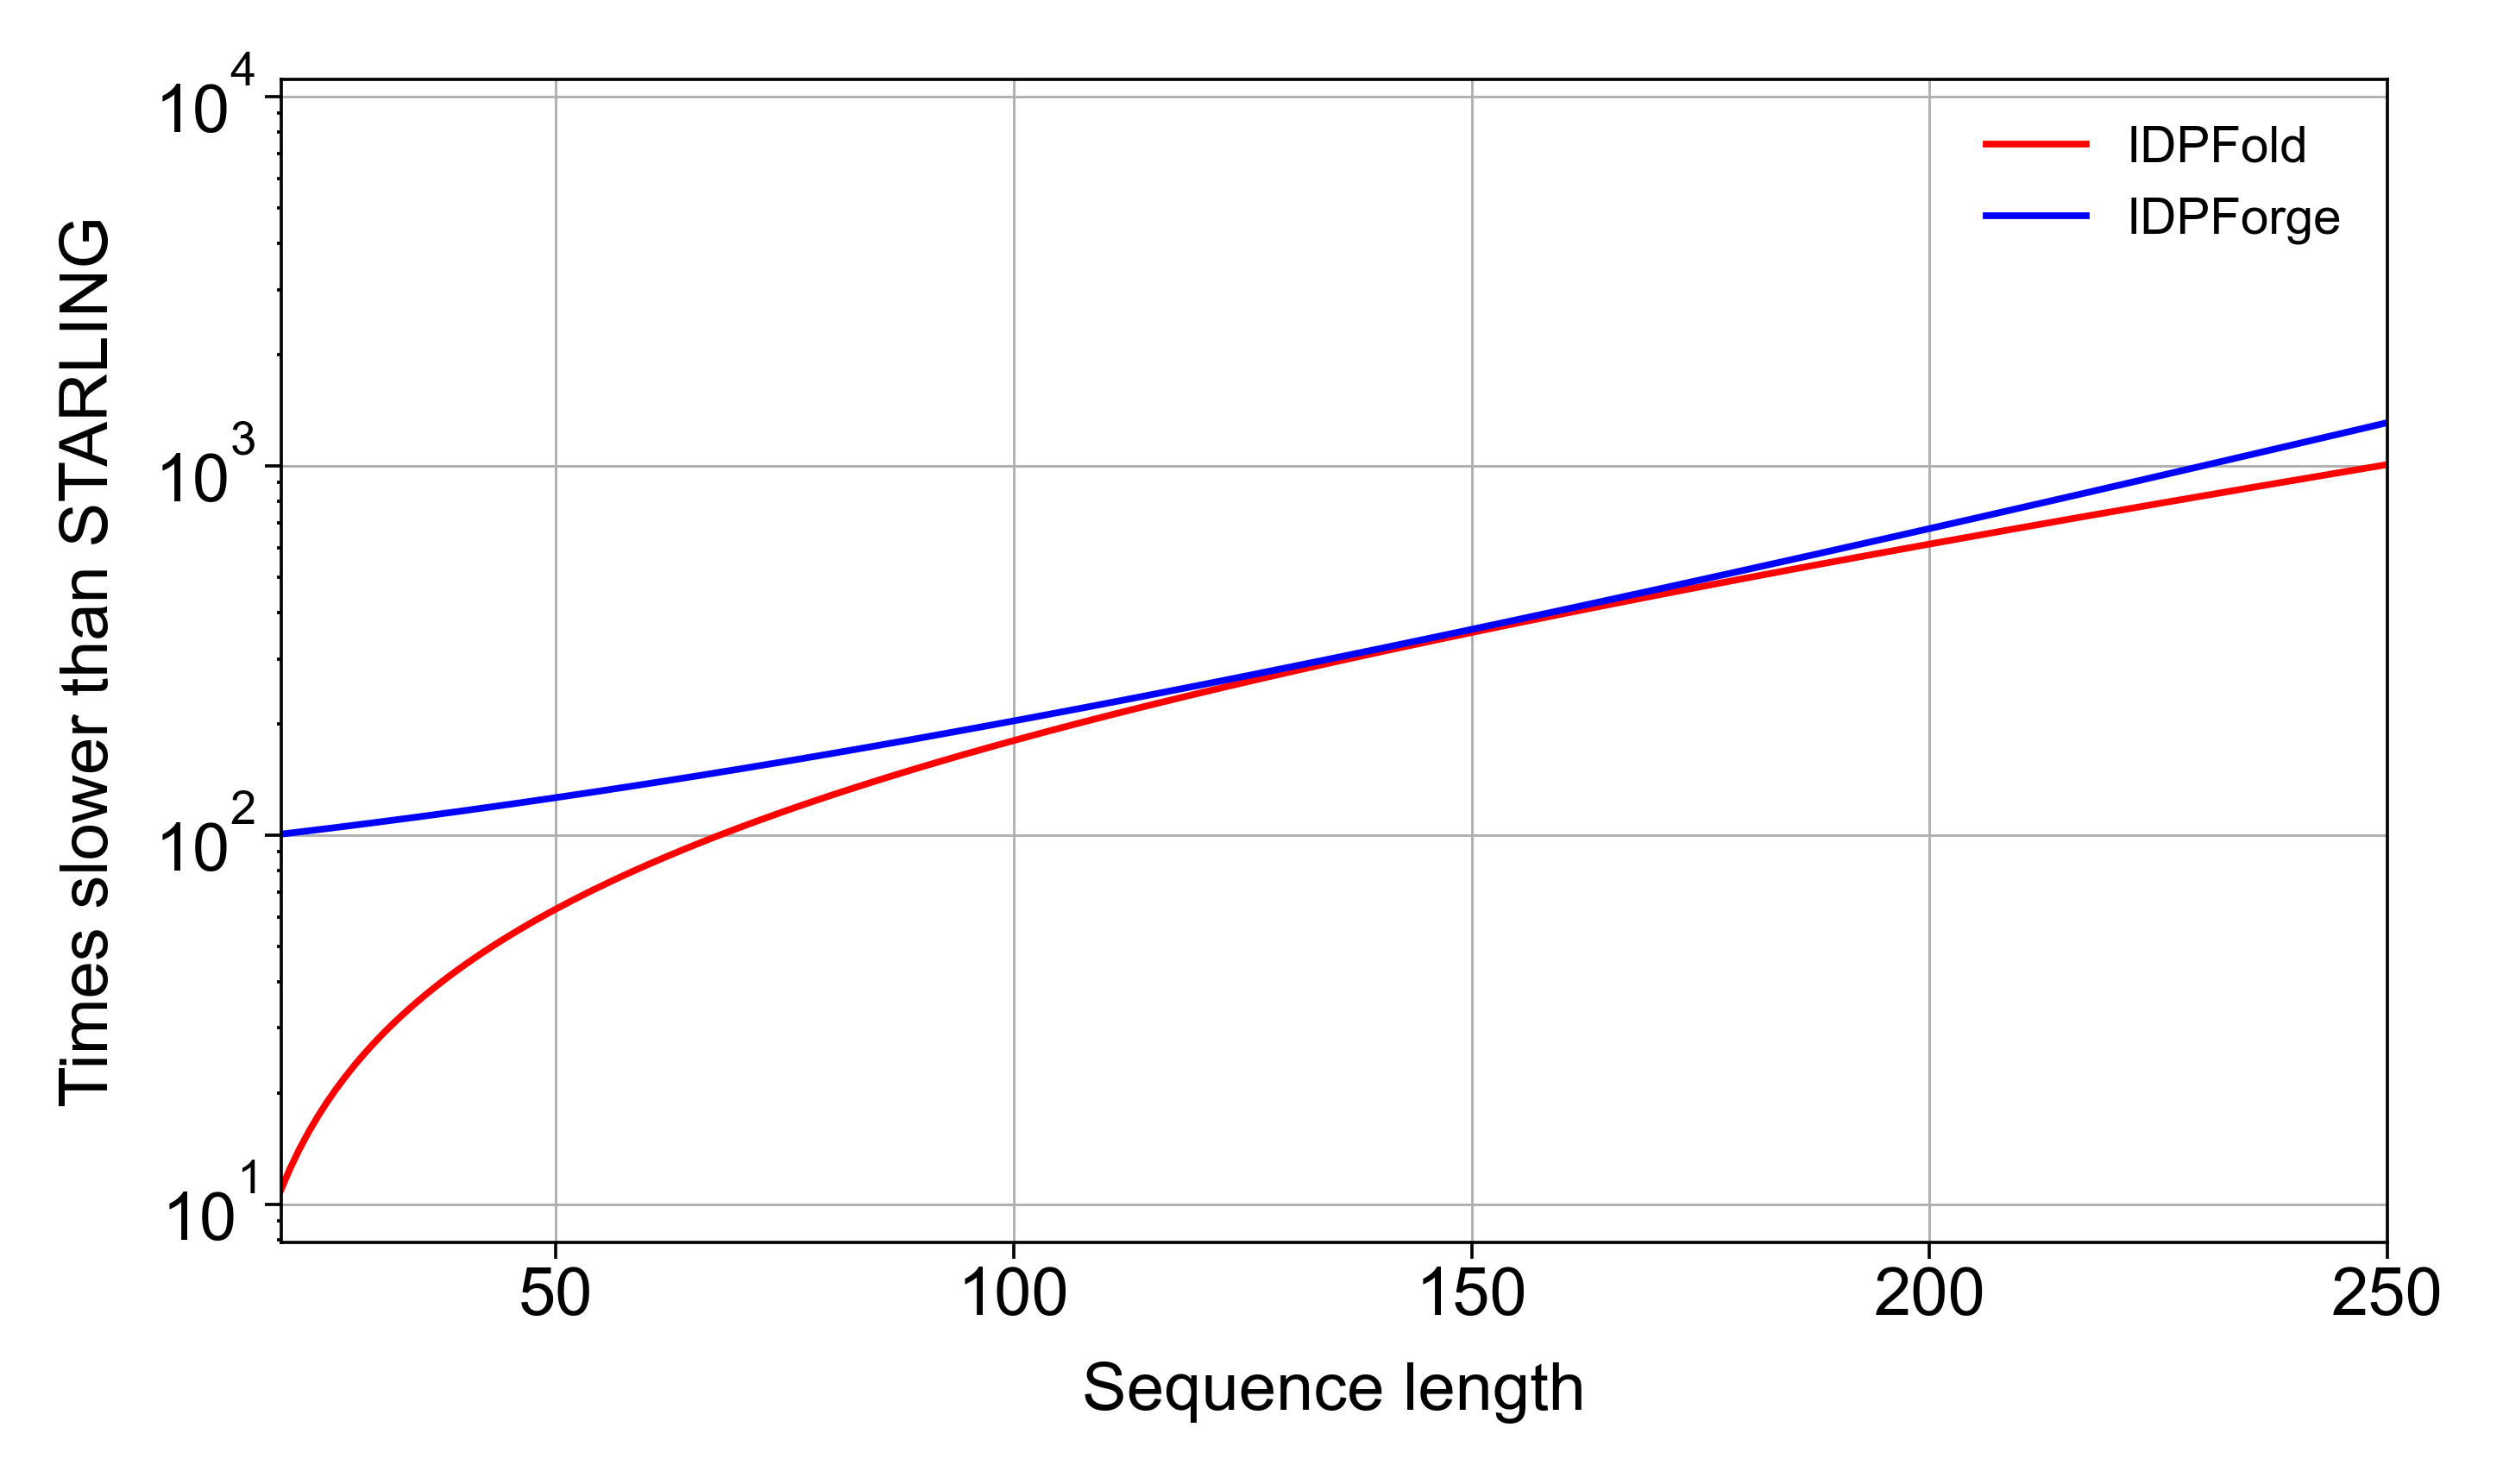

In [22]:
# compute relative speed of IDPFold and IDPForge vs STARLING
# note here larger number means STARLING is faster
USE_LOG = True
figure(None, (4.5,2.5), dpi=350)
ax = plt.gca()

plt.plot(xf_idpfold, yf_idpfold/yf_starling, ls='-',c='r', lw=0.8, label='IDPFold')
plt.plot(xf_idpforge, yf_idpforge/yf_starling, ls='-',c='b', lw=0.8, label='IDPForge')

plt.xlim([20,250])

plt.grid(lw=0.3)
plt.xlabel('Sequence length',fontsize=8)
plt.ylabel('Times slower than STARLING', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(frameon=False, fontsize=6)
if USE_LOG:
    plt.yscale('log')
    plt.savefig('figures/relative_speed.pdf')
else:
    plt.ylim([0,1500])    
    plt.yscale('linear')
    plt.savefig('figures/relative_speed_linear.pdf')


